0. **[Stuff](#0.-Stuff)**<br>
    0.1 [Imports](#0.1-Imports)<br>
    0.2 [Definitions](#0.2-Definitions)<br>

# 0. Stuff

## 0.1 Imports

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import colors
from matplotlib.colors import LogNorm
import math

%matplotlib inline
from scipy.optimize import curve_fit, minimize
import strax
import straxbra
from matplotlib.ticker import AutoMinorLocator
from matplotlib.image import NonUniformImage
import pandas as pd
import patrick_stylez as ps
from matplotlib.patches import Ellipse
import math
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import chi2 
import statistics

Using TensorFlow backend.


## 0.2 Definitions

In [2]:
ctx = straxbra.XebraContext()

In [3]:
run = '00230'
peaks_data = ctx.get_array(run, 'peaks')
# position_data = ctx.get_array(run, 'peak_positions')

In [4]:
waveform = peaks_data['data']
integral = peaks_data['area']
width = peaks_data['width'][:,5]
timestamp = peaks_data['time']
risetime = -peaks_data['area_decile_from_midpoint'][:,1]
area_per_channel = peaks_data['area_per_channel']

# 2. Functions

## 2.1 S1 correction

In [5]:
def compute_ly():

    z_absolute = []
    for i in range(len(z)):
        z_absolute.append(abs(z[i]))
    bins_x = np.linspace(0,80,40)
    bins_y = np.linspace(100,600,40)

    def poisson_interval(k, alpha=0.318):
        a = alpha
        low, high = (chi2.ppf(a/2, 2*k) / 2, chi2.ppf(1-a/2, 2*k + 2) / 2)
        if k == 0:
            low = 0.0
        low_interval = k - low
        high_interval = high - k
        return low_interval, high_interval

    counts, xedges, yedges = np.histogram2d(z_absolute, s1, bins=(bins_x, bins_y))
    xcenter = ((xedges[:-1]+xedges[1:])/2)
    ycenter = ((yedges[:-1]+yedges[1:])/2)
    poisson_list_left = []
    poisson_list_right = []

    for i in counts:
        error_per_slice_left = []
        error_per_slice_right = []
        for j in i:
            b =poisson_interval(j)[1]
            a =poisson_interval(j)[0]
            error_per_slice_left.append(a)
            error_per_slice_right.append(b)
        poisson_list_left.append(error_per_slice_left)
        poisson_list_right.append(error_per_slice_right)
        
    fit_range= np.linspace(100,600,1000)

    p0 = [1,250,30]
    
    expectation_list = []
    error_list = []
    for i in range(2,32):   
        popt, pcov = curve_fit(gaus, ycenter, counts[i], p0, sigma = poisson_list_right[i], absolute_sigma = True, maxfev=100000)
        perr = np.sqrt(np.diag(pcov))



        expectation = popt[1]
        error = perr[1]
        expectation_list.append(expectation)
        error_list.append(error)

#     print(expectation_list)
#     print(error_list)

    return expectation_list, error_list



## 2.2 S2 correction

In [6]:
def compute_lifetime(s2,drifttime):

    
    bins_x = np.linspace(0,50,40)
    bins_y = np.logspace(2,5,40) 
    drifttime = np.array(drifttime)
    counts, xedges, yedges = np.histogram2d(drifttime/1e3, s2, bins=(bins_x, bins_y))
    ycenter = ((yedges[:-1]+yedges[1:])/2)
    poisson_list = []
    for i in counts:
        error_per_slice = []
        for j in i:
            q =poisson_interval(j)[1]
            error_per_slice.append(q)
        poisson_list.append(error_per_slice)
        
    fit_range= np.linspace(10,30000,1000)

    

    p0 = [50,8,2]

    expectation_list = []
    error_list = []
    for i in range(5,30):   
        popt, pcov = curve_fit(log_gaus, ycenter, counts[i], p0= p0, sigma = poisson_list[i], absolute_sigma = True, maxfev = 10000)
        perr = np.sqrt(np.diag(pcov))

        expectation = np.exp(popt[1]+((popt[2]**2)/2))
        expectation_list.append(expectation)

    
        diff_mu = expectation
        diff_sigma = expectation*popt[2]
        error_mu = perr[1]
        error_sigma = perr[2]
    
        error = np.sqrt(diff_mu**2 * error_mu**2 + diff_sigma**2 * error_sigma**2)
        error_list.append(error)
    
 
    p1=  [10000,0.1]
    x = np.linspace(5,30,25)
    popt, pcov = curve_fit(expo, x, expectation_list, sigma=error_list, p0=p1, absolute_sigma=True, maxfev= 10000)
    perr = np.sqrt(np.diag(pcov))
    lifetime =(1/popt[1])
    lifetime_error =(1/(popt[1]**2))*perr[1]
#    print('electron lifetime: ', lifetime, '+/-', lifetime_error)
    
    return (lifetime, lifetime_error)


In [7]:
def log_gaus(x, h, mu, sigma):

    gaus = h * np.exp(-(np.log(x)-mu)**2         /(2*sigma**2))
    return gaus

def expo(x, a, b):
    return a*np.exp(-b*x)

def gaus(x, h, mu, sigma):

    gaus = h * np.exp(-(x-mu)**2         /(2*sigma**2))
    return gaus

def linear(x,m,c):
    linear = m*x+c  
    return linear

# def CutCondition(waveform):  
#     FirstPeak_area = sum(waveform[:15])
#     SecondPeak_area = sum(waveform[15:])    
#     if  FirstPeak_area > 80 and FirstPeak_area < 500 and SecondPeak_area > 30 and SecondPeak_area  < 200:
# #         print(FirstPeak_area)
# #         print(SecondPeak_area)
#         return(True)
#     else:
#         return(False)

    
def CutCondition(waveform):  
    FirstPeak_area = sum(waveform[:15])
    SecondPeak_area = sum(waveform[15:])
    FirstPeak_maximum = max(waveform[:15])
    SecondPeak_maximum = max(waveform[15:])
    SecondPeak_index = np.where(waveform == SecondPeak_maximum)
    SecondPeak_index_left = SecondPeak_index[0][0] -1
    SecondPeak_index_right = SecondPeak_index[0][0] +1
    SecondPeak_maximum_left = waveform[SecondPeak_index_left]
    SecondPeak_maximum_right = waveform[SecondPeak_index_right]




    if  FirstPeak_area > 100 and FirstPeak_area < 500 and SecondPeak_area > 40 and SecondPeak_area  < 200 \
    and SecondPeak_maximum < 0.5 * FirstPeak_maximum \
    and SecondPeak_maximum > 0.25 * FirstPeak_maximum \
    and SecondPeak_maximum > waveform[SecondPeak_index_left] \
    and SecondPeak_maximum > waveform[SecondPeak_index_right] \
    : 
        return(True)
    else:
        return(False)    

def drifttime_to_z(t):
    return a * t + b

def S2_found(integral, width):
    if integral > 500 and width >200 and width < 2000:
        return True
    else:
        return False
    
def poisson_interval(k, alpha=0.318):
    a = alpha
    low, high = (chi2.ppf(a/2, 2*k) / 2, chi2.ppf(1-a/2, 2*k + 2) / 2)
    if k == 0:
        low = 0.0
    low_interval = k - low
    high_interval = high - k
    return low_interval, high_interval


def Process(waveform, i): 
    SelectionCutFlag = CutCondition(waveform[i])
    if SelectionCutFlag == True:
#         print(SelectionCutFlag)
#         print(i)
        j = 1
        counter_timestamp = timestamp[i+j]
        threshold_timestamp = timestamp[i] + 45000
        while threshold_timestamp >= counter_timestamp and  S2_found(integral = integral[i+j], width = width[i+j]) == False:  
            j += 1
            counter_timestamp = timestamp[i+j]
        else:
            if S2_found(integral = integral[i+j], width = width[i+j]):

                k=1 
                s2_counter_timestamp = timestamp[i+j+k]
                z_position = drifttime_to_z(timestamp[i+j] - timestamp[i])
                while threshold_timestamp >= s2_counter_timestamp and S2_found(integral = integral[i+j+k], width = width[i+j+k]) == False:
                    k += 1
                    s2_counter_timestamp = timestamp[i+j+k]
                else:

                    if threshold_timestamp <= s2_counter_timestamp and z_position >= -70 and z_position <= -5:

                        time       = timestamp[i+j] - timestamp[i]
                        drifttime.append(time)
                        s2.append(integral[i+j])
                        s1.append(integral[i])
                        z.append(z_position)


                return
            else:
                return
            
            
def Process_corrected(waveform, i, electron_lifetime): 
    SelectionCutFlag = CutCondition(waveform[i])
    if SelectionCutFlag == True:
        j = 1
        counter_timestamp = timestamp[i+j]
        threshold_timestamp = timestamp[i] + 45000
        while threshold_timestamp >= counter_timestamp and  S2_found(integral = integral[i+j], width = width[i+j]) == False:  
            j += 1
            counter_timestamp = timestamp[i+j]
        else:
            if S2_found(integral = integral[i+j], width = width[i+j]):

                k=1 
                s2_counter_timestamp = timestamp[i+j+k]

                z_position = drifttime_to_z(timestamp[i+j] - timestamp[i])
                while threshold_timestamp >= s2_counter_timestamp and S2_found(integral = integral[i+j+k], width = width[i+j+k]) == False:
                    k += 1
                    s2_counter_timestamp = timestamp[i+j+k]
                else:


                    if threshold_timestamp <= s2_counter_timestamp and z_position >= -70 and z_position <= -5:

                        ctime       = timestamp[i+j] - timestamp[i]
                        drifttime_corrected.append(ctime)
                        cs1.append(integral[i]/(shape*z_position+offset))
                        S2 = integral[i+j]
                        s2_corrected = S2/(np.exp(-ctime/(electron_lifetime*1e3)))
                        cs2.append(s2_corrected)


                return
            else:
                return

In [8]:

left_edge  = [0, 0]
right_edge = [40500.0, -71.5]
a = ((right_edge[1])-(left_edge[1])) / ((right_edge[0])-(left_edge[0]))
b = (right_edge[1]) - a * (right_edge[0])

s1 = []
s2 = []
drifttime = []
z = []
                                                
num = len(waveform)
print_counter = 0.0
for i in range(0,num-10):    
    Process(waveform,i)
    if i/num >= print_counter:
        print(round(print_counter,2), end = ' ')
        print_counter += 0.1
print(1.0, '        Run ',run, 'done!')
    

0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0         Run  00230 done!


In [9]:
electron_lifetime, lifetime_error = compute_lifetime(s2,drifttime)    
print('This is the electron lifetime', electron_lifetime, '+/-', lifetime_error)
ly_z = compute_ly()
#print(ly_z)

This is the electron lifetime 9.775332518889735 +/- 0.08212704398224778


average ly of run 230 : ( 5.61 +/- 0.01 ) keV/pe


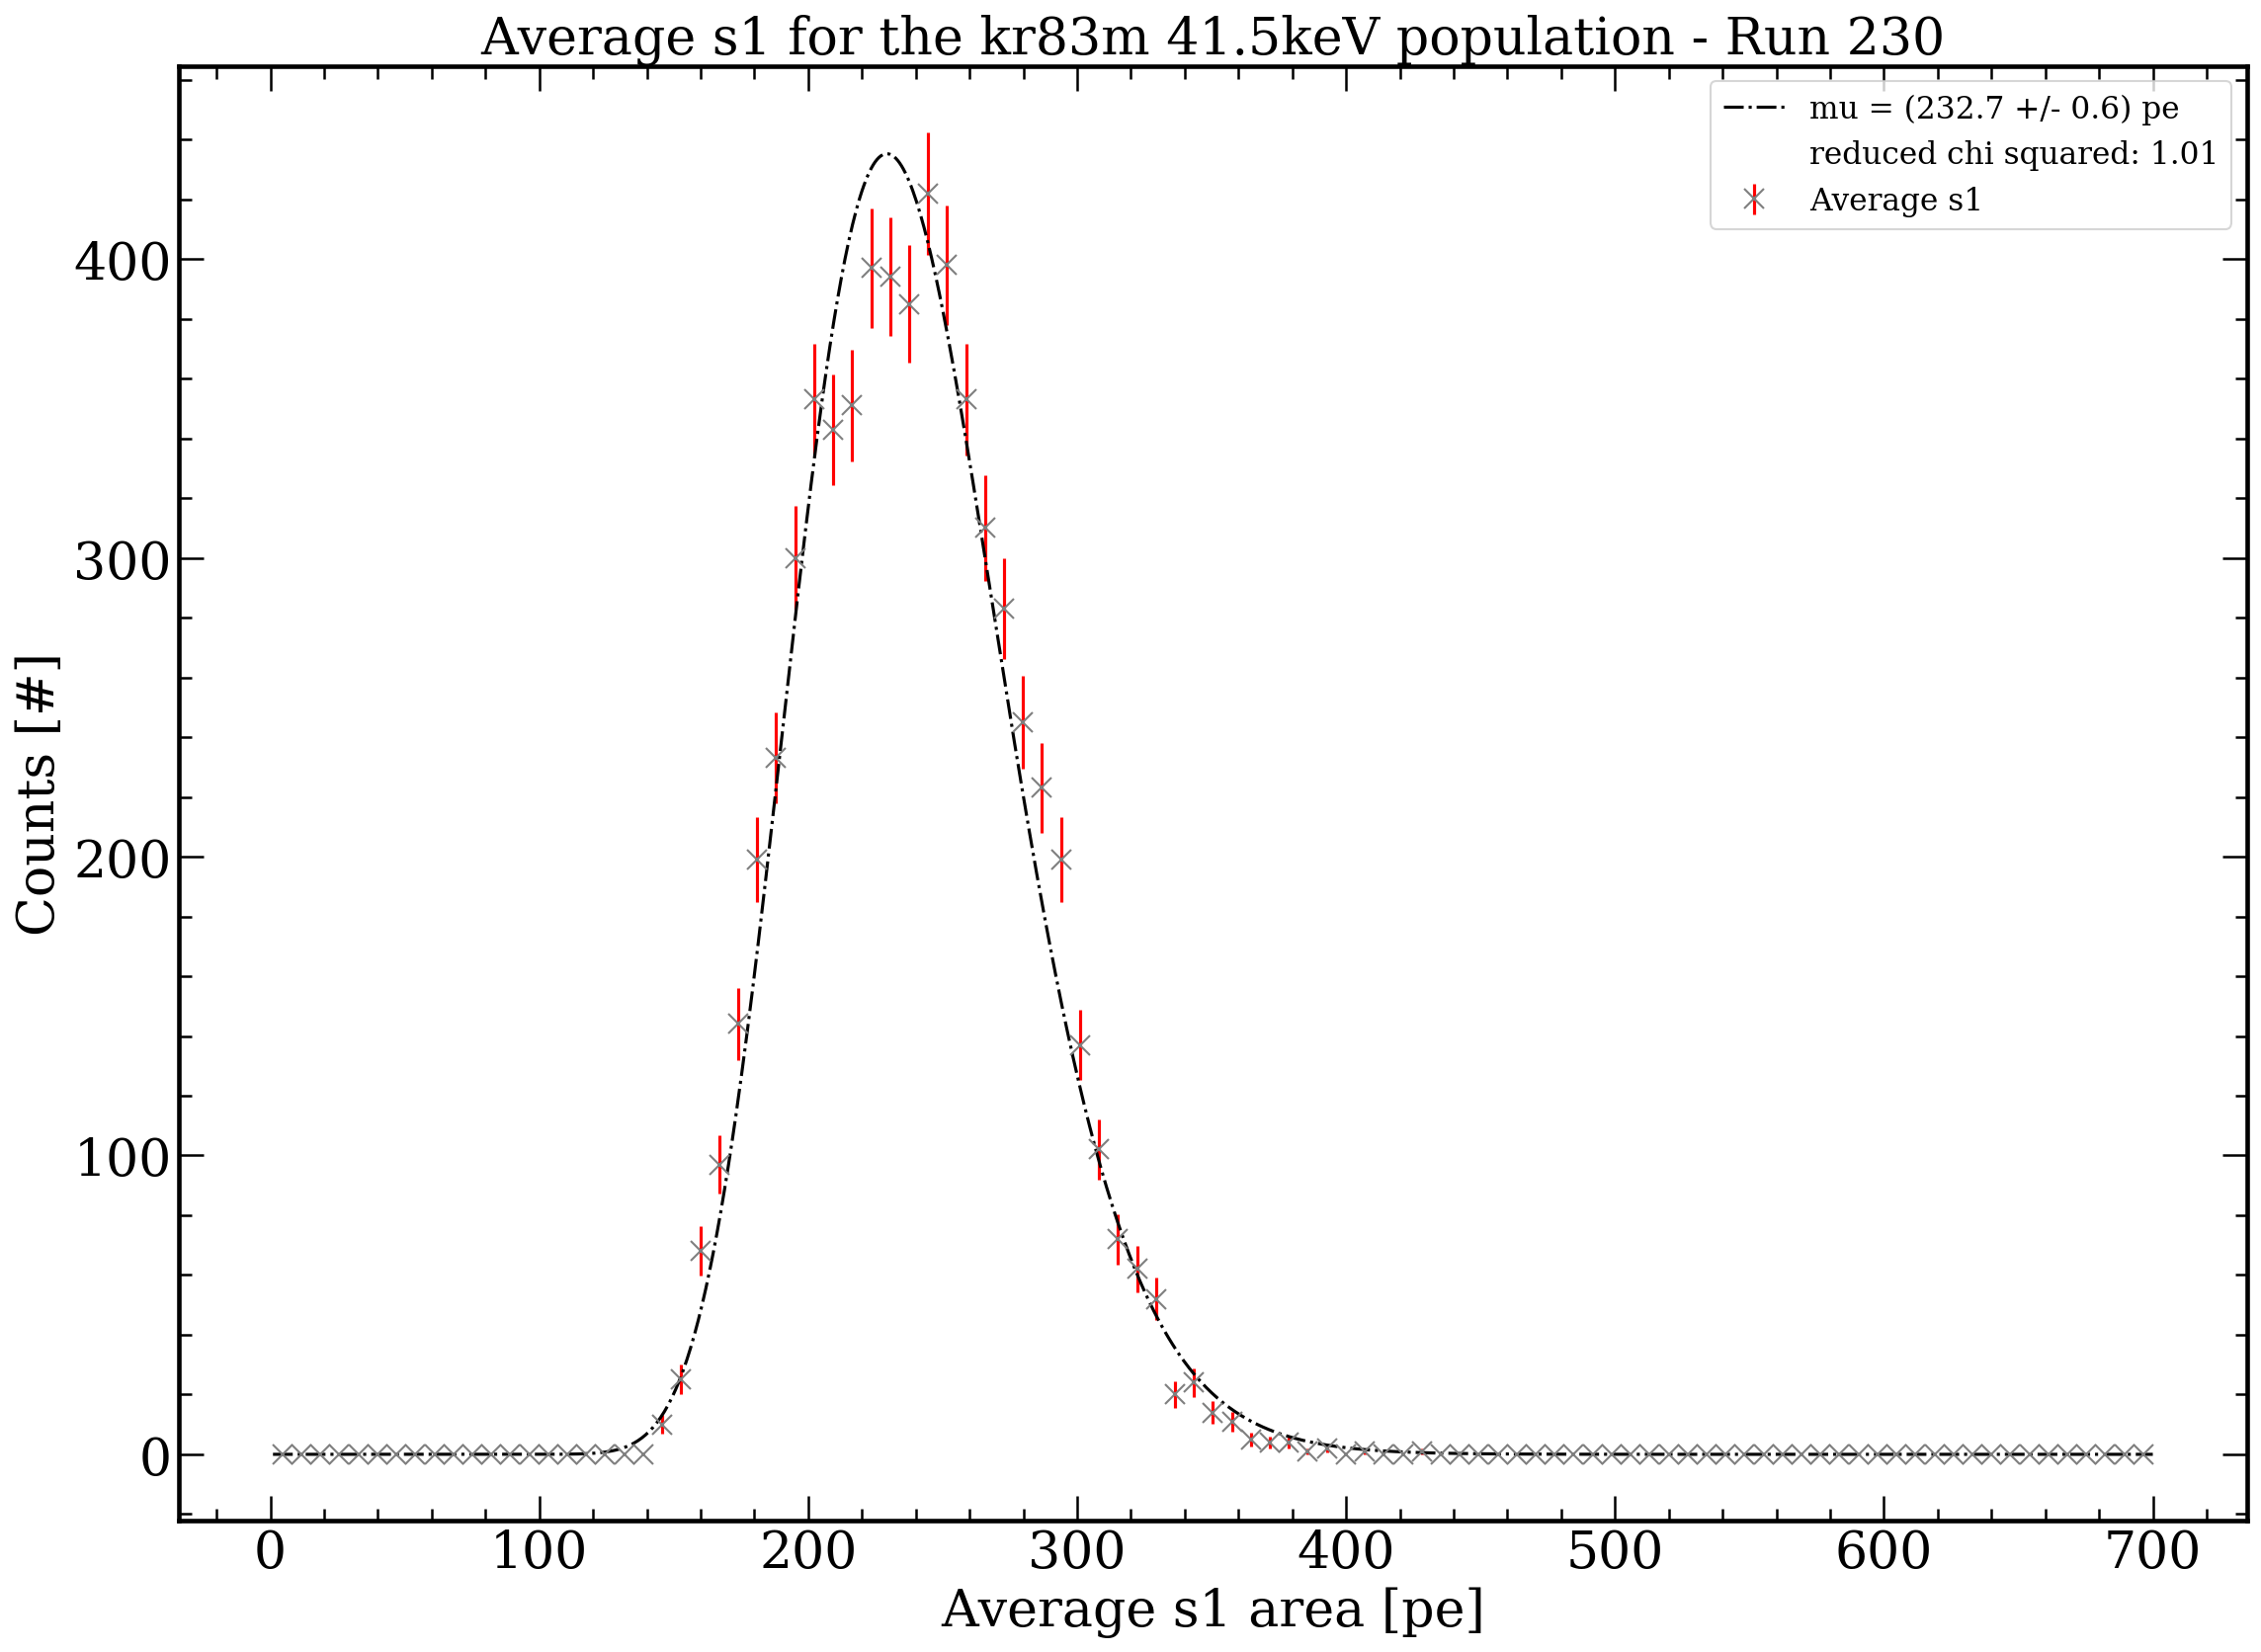

In [21]:
fig, axes = ps.styles()

p0_log = [1,1,1]
p0 = [500,300,60]


n, binEdges = np.histogram(s1, bins=np.linspace(1,700,100))  #anode at 2500V

poisson_list = []

for i in n:
    a= poisson_interval(i)[1]
    poisson_list.append(a)


bincenters = 0.5 * (binEdges[1:] + binEdges[:-1])
x_range = np.linspace(1,700,1000)

popt, pcov = curve_fit(log_gaus, bincenters, n, p0_log,  sigma = poisson_list, absolute_sigma = True, maxfev = 10000)
perr = np.sqrt(np.diag(pcov))




expectation = np.exp(popt[1]+((popt[2]**2)/2))
diff_mu = expectation
diff_sigma = expectation*popt[2]
error_mu = perr[1]
error_sigma = perr[2]   
error = np.sqrt(diff_mu**2 * error_mu**2 + diff_sigma**2 * error_sigma**2)

s1_mu = f"{expectation:.1f}"


s1_ly = f"{(np.array(expectation)/41.5):.2f}"
s1_ly_error = f"{(np.array(error)/41.5):.2f}"
print('average ly of run',run[2:],': (',s1_ly,'+/-',s1_ly_error,')','keV/pe')
s1_error = f"{error:.1f}"




xdata=bincenters[1:-1]
ydata=n[1:-1]
chi_squared =  (np.sum((n - log_gaus(bincenters, *popt))**2 / np.array(poisson_list)**2))
Reduced_chi_squared ="%.2f" %( chi_squared / len(xdata))
# print(Reduced_chi_squared)



axes.errorbar(bincenters, n, yerr=np.sqrt(n),marker = 'x', fmt='.',c = 'C7',markersize='10', ecolor='red', label='Average s1')
axes.plot(x_range,log_gaus(x_range,*popt), color = 'k', linestyle = '-.', label = 'mu = ('+s1_mu+ ' +/- '+s1_error+') pe')
axes.plot([], [], ' ', label="reduced chi squared: "+Reduced_chi_squared)
axes.set_title('Average s1 for the kr83m 41.5keV population - Run '+run[2:])
axes.set_ylabel('Counts [#]')
axes.set_xlabel('Average s1 area [pe]')
axes.legend(loc = 1, prop={'size': 15})
plt.show()


In [11]:
p0=  [10,6]

s1_ly = float(s1_ly)
expectation_list, error_list = ly_z
expectation = (np.array(expectation_list))/(41.5)

error = float(s1_error)
relative_ly = np.array(expectation)/s1_ly
error = (np.array(error_list))/(41.5)
relative_error = (np.array(error))/s1_ly

x_range = np.linspace(-5,-65,30)

popt, pcov = curve_fit(linear, x_range, relative_ly, sigma=error, p0=p0, absolute_sigma=True, maxfev= 10000)
perr = np.sqrt(np.diag(pcov))
shape = f"{popt[0]:.4f}"
shape_error = perr[0]
offset_error = perr[1]
offset = f"{popt[1]:.2f}"

print('This is the s1 correction function: ', shape,'*z +',offset)


This is the s1 correction function:  -0.0068 *z + 0.77


In [12]:

left_edge  = [0, 0]
right_edge = [40500.0, -71.5]
a = ((right_edge[1])-(left_edge[1])) / ((right_edge[0])-(left_edge[0]))
b = (right_edge[1]) - a * (right_edge[0])

cs2 = []
drifttime_corrected=[]
cs1=[]
shape = float(shape)
offset = float(offset) 
                                                
num = len(waveform)
print_counter = 0.0
for i in range(0,num-10):    
    Process_corrected(waveform,i,electron_lifetime)
    if i/num >= print_counter:
        print(round(print_counter,2), end = ' ')
        print_counter += 0.1
print(1.0, '        Run ',run, 'done!')
    

0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0         Run  00230 done!


In [13]:

# cs2_mean = np.mean(cs2)
# cs1_mean = np.mean(cs1)
# cs2_sigma = statistics.stdev(cs2)
# cs1_sigma = statistics.stdev(cs1)

# print(type(cs2_mean), type(cs1_mean))
# print(type(cs2_sigma), type(cs1_sigma))

# A = 10
# B=10   
# Q = (np.cos(B)**2)/(2*cs1_sigma**2)
# R = (np.sin(B)**2)/(2*cs2_sigma**2)
# S = (cs1-cs1_mean)**2

# print()
# print(type(cs1), len(cs1))
# print(type(A), type(B), type(Q))
# print(type(R), type(S))
    
# T = (np.sin(2*B))/(4*cs1_sigma**2)
# U = (np.sin(2*B))/(4*cs2_sigma**2)
# V = (cs2-cs2_mean)

# print()
# print(type(T), type(U), type(V))
    
# W = (np.sin(B)**2)/(2*cs1_sigma**2)
# X = (np.cos(B)**2)/(2*cs2_sigma**2)
# Y = V**2

# print()
# print(type(W), type(X), type(Y))
    
    
# full_fit = A*np.exp(-((Q+R)*S+2*(-T+U)*V*S+(W+X)*Y))

# print(type(full_fit))
# print(len(full_fit))

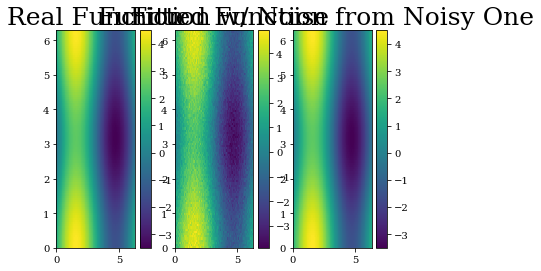

In [14]:
# curvefit with non linear least squares (curve_fit function)
import numpy as np
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a*np.sin(x[0])+b*np.cos(x[1])+c

limits = [0, 2*np.pi, 0, 2*np.pi]  # [x1_min, x1_max, x2_min, x2_max]
side_x = np.linspace(limits[0], limits[1], 100)
side_y = np.linspace(limits[2], limits[3], 100)
X1, X2 = np.meshgrid(side_x, side_y)
size = X1.shape
x1_1d = X1.reshape((1, np.prod(size)))
x2_1d = X2.reshape((1, np.prod(size)))

xdata = np.vstack((x1_1d, x2_1d))
original = (3, 1, 0.5)
z = func(xdata, *original)
Z = z.reshape(size)
z_noise = z + .2*np.random.randn(len(z))
Z_noise = z_noise.reshape(size)

ydata = z_noise
popt, pcov = curve_fit(func, xdata, ydata)

z_fit = func(xdata, *popt)
Z_fit = z_fit.reshape(size)

import matplotlib.pyplot as plt
plt.subplot(1, 3, 1)
plt.title("Real Function")
plt.pcolormesh(X1, X2, Z)
plt.axis(limits)
plt.colorbar()
plt.subplot(1, 3, 2)
plt.title("Function w/ Noise")
plt.pcolormesh(X1, X2, Z_noise)
plt.axis(limits)
plt.colorbar()
plt.subplot(1, 3, 3)
plt.title("Fitted Function from Noisy One")
plt.pcolormesh(X1, X2, Z_fit)
plt.axis(limits)
plt.colorbar()

plt.show()

In [15]:
print(ydata)

[1.55108267 2.03471311 1.99134677 ... 0.73531312 1.48564048 1.55502189]


In [16]:
# x_range = np.array((xedges[:-1] + xedges[1:]) / 2)
# y_range = np.array((yedges[:-1] + yedges[1:]) / 2)

# x1, x2 = np.meshgrid(x_range, y_range)
# print(x1.shape)
# size_x1 = x1.shape
# x1_1d = x1.reshape((1, np.prod(size_x1)))
# x2_1d = x2.reshape((1, np.prod(size_x1)))
# x_data = np.vstack((x1_1d, x2_1d))
# print(type(x1_1d))
# print(x1_1d.shape)
# print(x_data.shape)

# size_y_data = counts.shape
# y_data_1d = counts.reshape((1, np.prod(size_y_data)))
# y_data = y_data_1d[0]


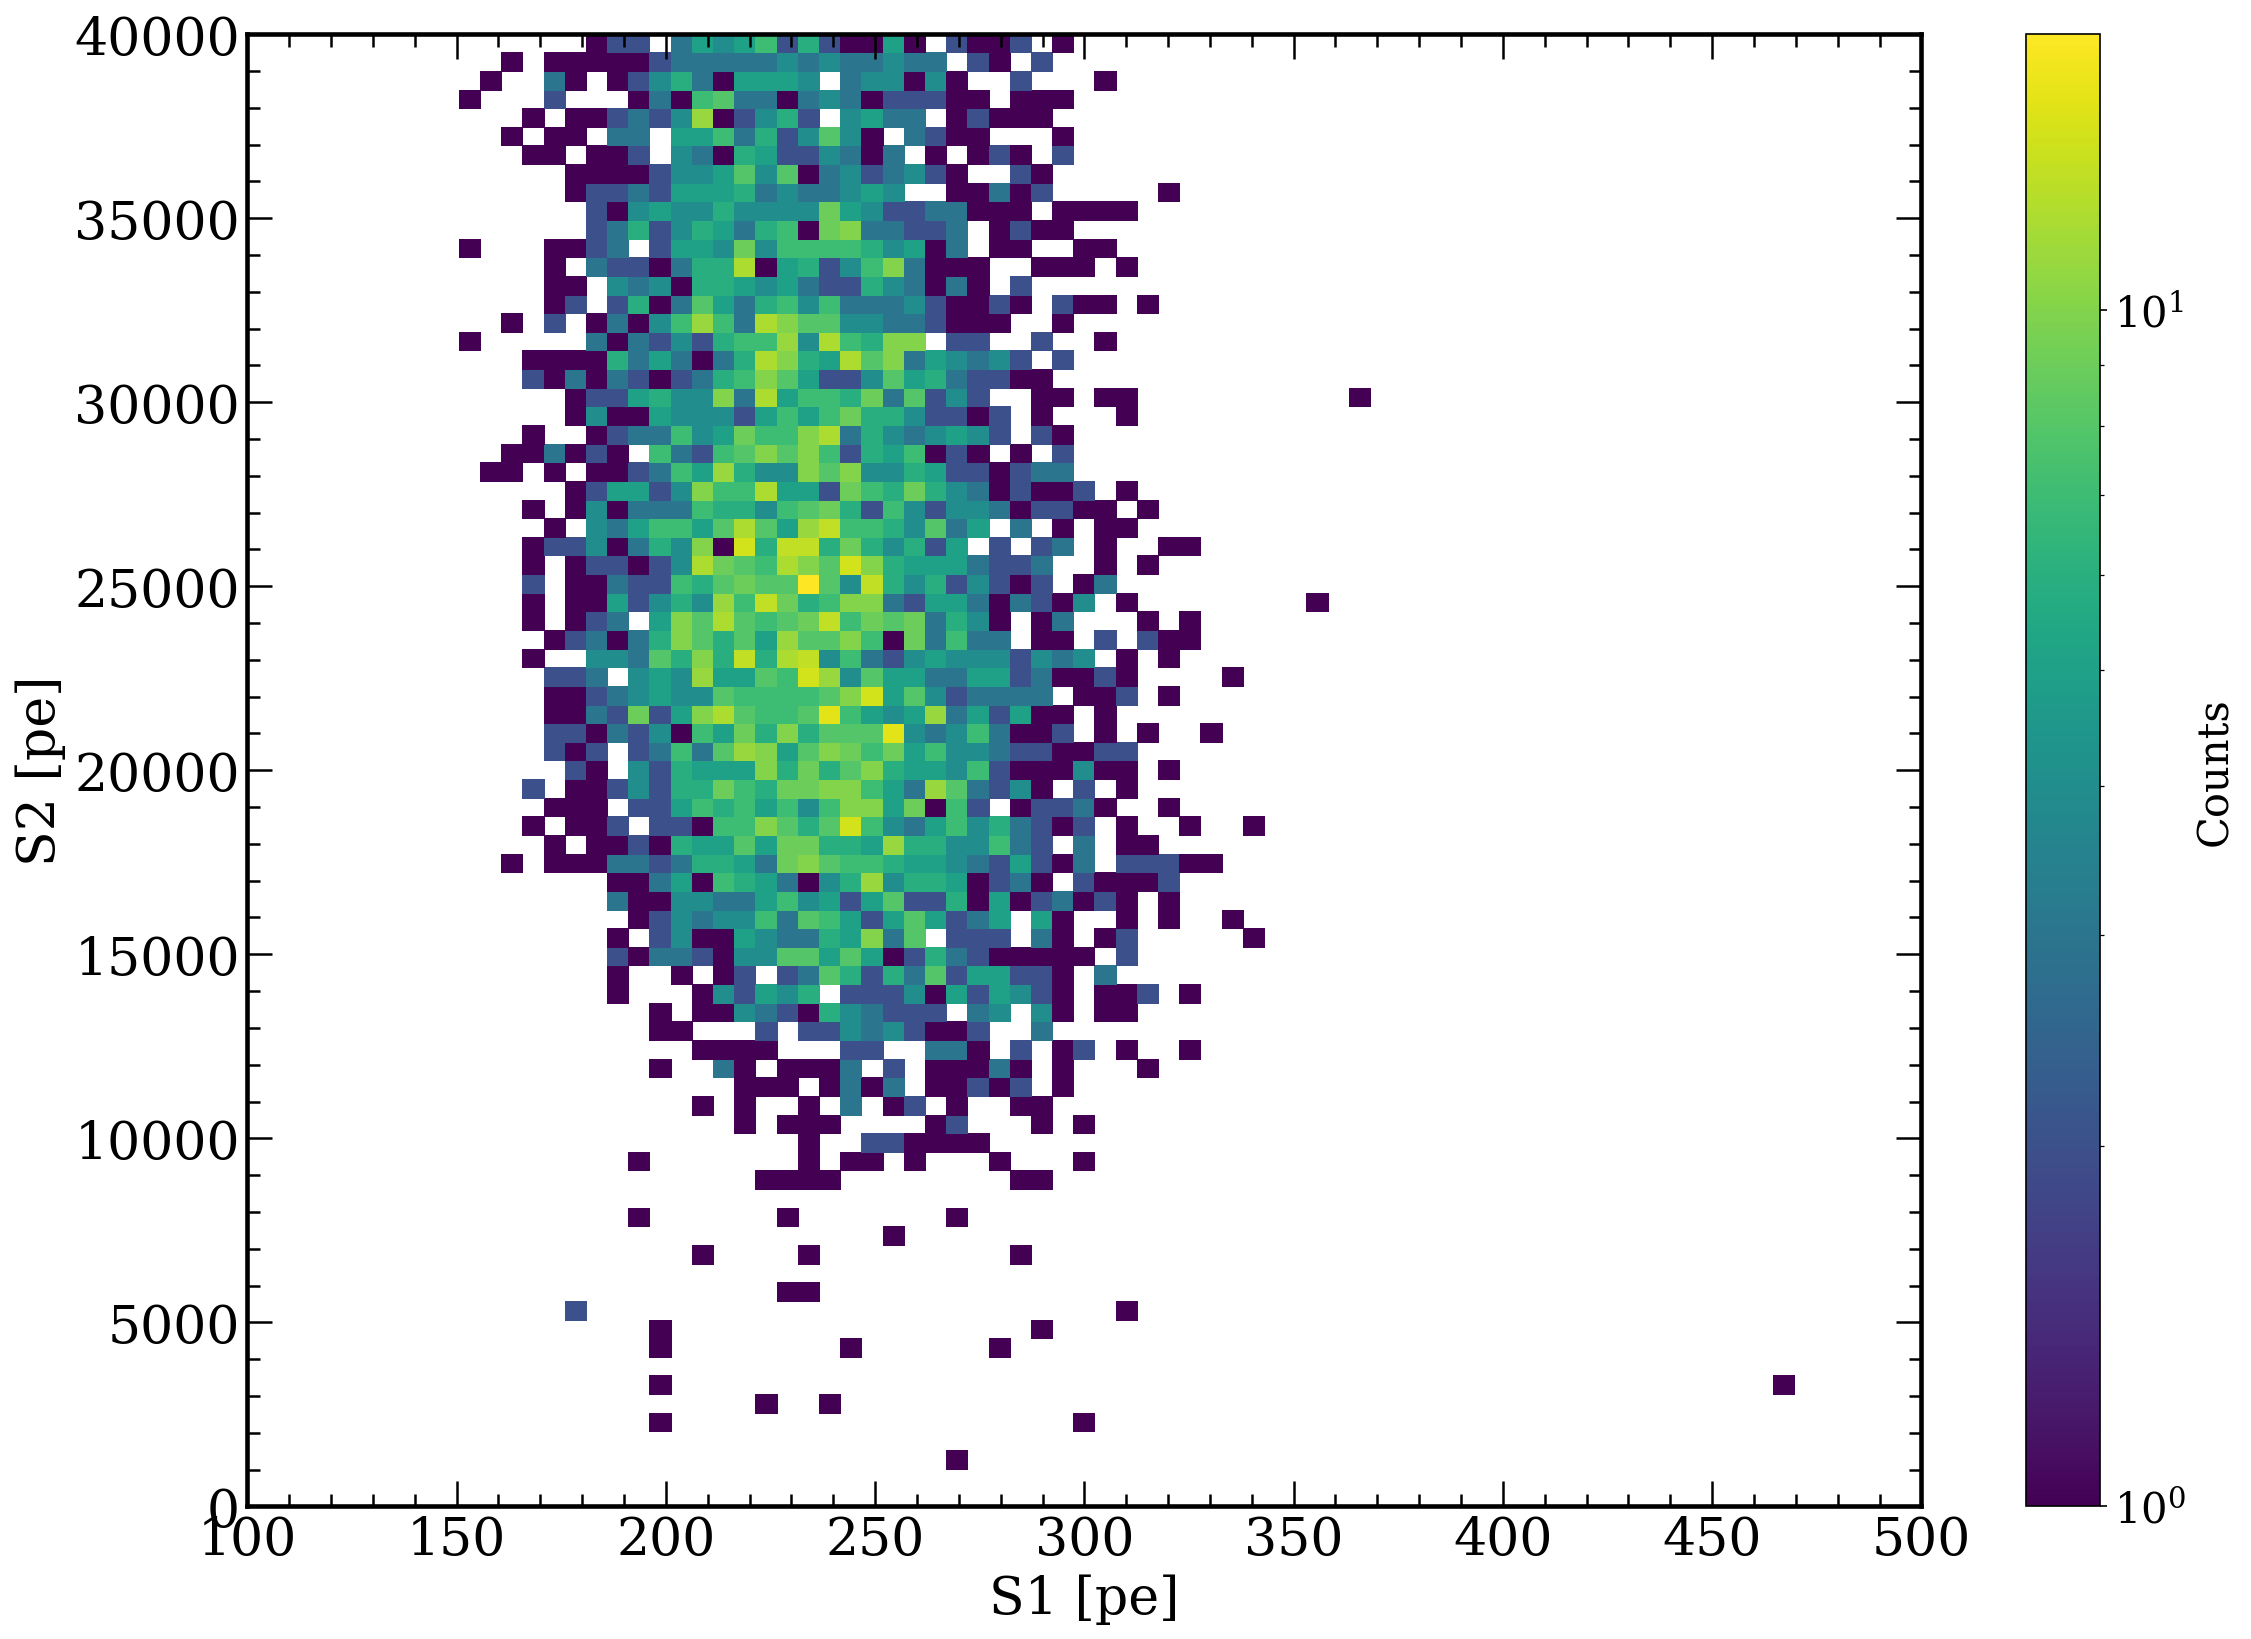

In [17]:
fig, axes = ps.styles()

def fit(cs1, cs2,A,B):
    cs2_mean = np.mean(cs2)
    cs1_mean = np.mean(cs1)
    #cs2_sigma = statistics.stdev(cs2)
    #cs1_sigma = statistics.stdev(cs1)
    cs2_sigma = np.std(cs2)
    cs1_sigma = np.std(cs1)
    
    Q = (np.cos(B)**2)/(2*cs1_sigma**2)
    R = (np.sin(B)**2)/(2*cs2_sigma**2)
    S = (cs1-cs1_mean)**2
    
    T = (np.sin(2*B))/(4*cs1_sigma**2)
    U = (np.sin(2*B))/(4*cs2_sigma**2)
    V = (cs2-cs2_mean)
    
    W = (np.sin(B)**2)/(2*cs1_sigma**2)
    X = (np.cos(B)**2)/(2*cs2_sigma**2)
    Y = V**2
    
    full_fit = A*np.exp(-((Q+R)*S+2*(-T+U)*V*S+(W+X)*Y))
    return full_fit

bins_x = np.linspace(100,500,80)
bins_y = np.linspace(0,40000,80)
p0 = [10,10]
counts, xedges, yedges = np.histogram2d(cs1, cs2, bins=(bins_x, bins_y))
xcenters = np.array((xedges[:-1] + xedges[1:]) / 2)
ycenters = np.array((yedges[:-1] + yedges[1:]) / 2)


#popt, pcov = curve_fit(fit,(xcenters, ycenters), counts)
#popt, pcov = curve_fit(fit,np.array([xcenters.tolist(), ycenters.tolist()]), counts)
#popt, pcov = curve_fit(fit,np.array([xcenters, ycenters]), counts)


im = axes.pcolormesh(bins_x, bins_y, counts.T, norm=mpl.colors.LogNorm(), cmap = 'viridis')
#axes.scatter(x_value, y_value, c = 'c', s=10)

cb = plt.colorbar(im, ax=axes, label='Counts/bin')
cb.set_label('Counts',size=20)
cb.ax.tick_params(labelsize=20) 
# axes.set_xscale('log')
# axes.set_yscale('log')
# axes.set_xlim([0,500])
# axes.set_ylim([0,50000])
axes.set_xlabel('S1 [pe]')
axes.set_ylabel('S2 [pe]')


plt.show()


In [18]:
# fig, axes = ps.styles()

# def fit(cs1, cs2,A,B):
#     cs2_mean = np.mean(cs2)
#     cs1_mean = np.mean(cs1)
#     #cs2_sigma = statistics.stdev(cs2)
#     #cs1_sigma = statistics.stdev(cs1)
#     cs2_sigma = np.std(cs2)
#     cs1_sigma = np.std(cs1)
    
#     Q = (np.cos(B)**2)/(2*cs1_sigma**2)
#     R = (np.sin(B)**2)/(2*cs2_sigma**2)
#     S = (cs1-cs1_mean)**2
    
#     T = (np.sin(2*B))/(4*cs1_sigma**2)
#     U = (np.sin(2*B))/(4*cs2_sigma**2)
#     V = (cs2-cs2_mean)
    
#     W = (np.sin(B)**2)/(2*cs1_sigma**2)
#     X = (np.cos(B)**2)/(2*cs2_sigma**2)
#     Y = V**2
    
#     full_fit = A*np.exp(-((Q+R)*S+2*(-T+U)*V*S+(W+X)*Y))
#     return full_fit



# x_range = np.array((xedges[:-1] + xedges[1:]) / 2)
# y_range = np.array((yedges[:-1] + yedges[1:]) / 2)

# x1, x2 = np.meshgrid(x_range, y_range)
# # print(x1.shape)
# size_x1 = x1.shape
# x1_1d = x1.reshape((1, np.prod(size_x1)))
# x2_1d = x2.reshape((1, np.prod(size_x1)))
# x_data = np.vstack((x1_1d, x2_1d))
# # print(type(x1_1d))
# # print(x1_1d.shape)
# # print(x_data.shape)

# size_y_data = counts.shape
# y_data_1d = counts.reshape((1, np.prod(size_y_data)))
# y_data = y_data_1d[0]
# #popt, pcov = curve_fit(fit, x_data, y_data)
# print(x_data.shape)
# print(y_data.shape)

/software/anaconda3/envs/strax/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Ellipse(xy=(234.48357683751604, 29787.067208512566), width=36651.24796447629, height=175.1720527442186, angle=90.05418319163839)


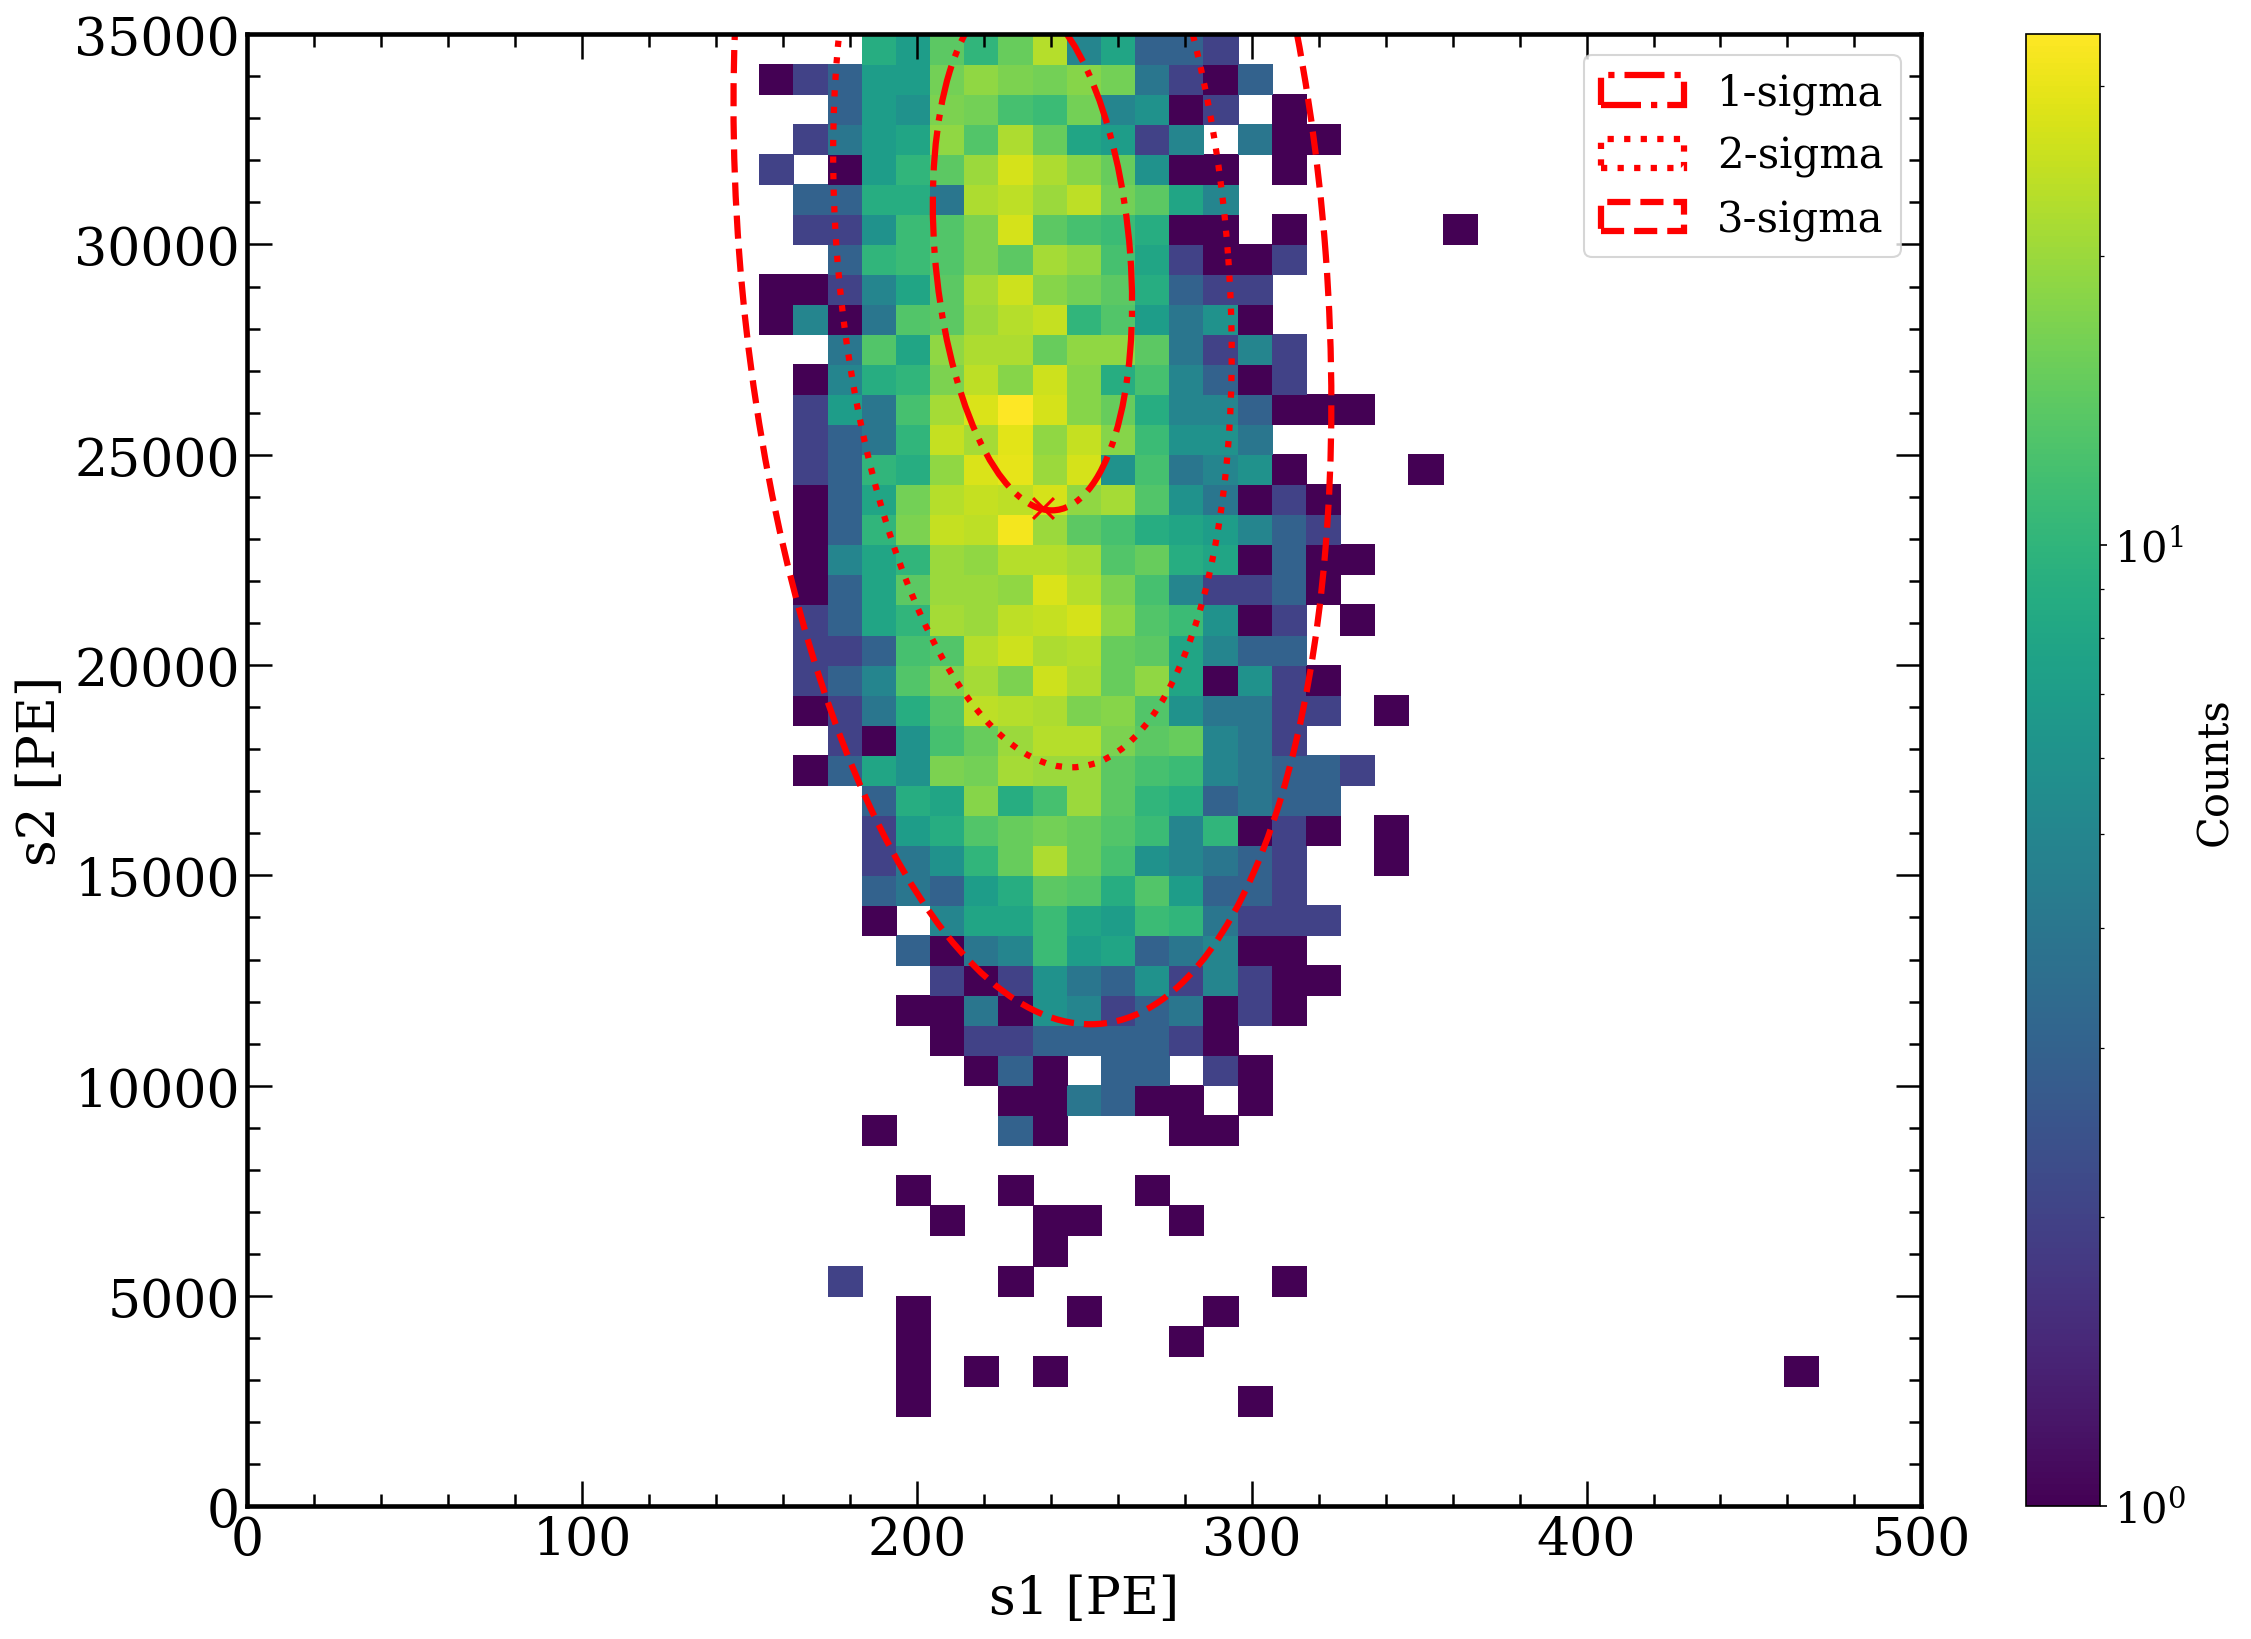

4693


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]


fig, axes = ps.styles()

x = cs1
y = cs2
# y_mean = np.mean(y)
# x_mean = np.mean(x)

x_value = []
y_value = []

for i in range(len(y)):
    if y[i] > 2000 and y[i] < 35000:
        x_value.append(x[i])
        y_value.append(y[i])

        
y_mean = np.mean(y_value)
x_mean = np.mean(x_value)


ax = plt.subplot(111)

cov = np.cov(x_value, y_value)
vals, vecs = eigsorted(cov)


nstd = [1,2,3]
colors = ['red']
#colors = ['navy', 'slateblue', 'blue']
label = ['1-sigma', '2-sigma', '3-sigma']
line = ['-.', ':', '--']

ell_list = []
for i in range(len(nstd)):
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    w, h = 2 * nstd[i] * np.sqrt(vals)
    ell = Ellipse(xy=(np.mean(x), np.mean(y)),
                  width=w, height=h,
                  angle=theta, color=colors[0], linewidth = 3, linestyle = line[i], label =label[i])
    ell.set_facecolor('none')
    ell_list.append(ell)
    
for i in ell_list:
    ax.add_artist(i)

    
    

print(ell)




bins_x = np.linspace(0,500,50)
bins_y = np.linspace(0,35000,50)
counts, xedges, yedges = np.histogram2d(x_value, y_value, bins=(bins_x, bins_y))
xcenters = np.array((xedges[:-1] + xedges[1:]) / 2)
ycenters = np.array((yedges[:-1] + yedges[1:]) / 2)


#popt, pcov = curve_fit(fit,(xcenters, ycenters), counts)
#popt, pcov = curve_fit(fit,np.array([xcenters.tolist(), ycenters.tolist()]), counts)
#popt, pcov = curve_fit(fit,np.array([xcenters, ycenters]), counts)


im = axes.pcolormesh(bins_x, bins_y, counts.T, norm=mpl.colors.LogNorm(), cmap = 'viridis')
#axes.scatter(x_value, y_value, c = 'c', s=10)

cb = plt.colorbar(im, ax=axes, label='Counts/bin')
cb.set_label('Counts',size=20)
cb.ax.tick_params(labelsize=20) 



# axes.scatter(x_value, y_value, c='C7', s=10, alpha = 0.5)
axes.scatter(x_mean, y_mean, c ='r', s=100, marker = 'x', label = 'mean')
axes.legend(loc = 1, prop={'size': 20}, handles=ell_list)





# axes.set_xlim([0,500])
# axes.set_ylim([0,35000])
axes.set_xlabel('s1 [PE]')
axes.set_ylabel('s2 [PE]')
plt.show()
print(len (x_value))

In [20]:
# xdat = np.vstack((xcenters.ravel(),ycenters.ravel()))
# print(xdata.shape)
# ydat = counts.ravel()
# print(ydata.shape)
# popt, pcov = curve_fit(fit, xdat, ydat)